How to do Guidance for Binomial Distribution?

during inference with Gaussian, the formula is:

residual = residual_uncond + guidance_scale * (residual_cond - residual_uncond)

But this might not work with a binary maks

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import diffusers
from tqdm import tqdm
from IPython.display import display, clear_output
from torchvision import transforms
import torchvision

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from diffusers import UNet2DModel

import datasets
from torch.utils.data import DataLoader, Dataset, TensorDataset
from PIL import Image

c:\Mine\Master\MyNca\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class BinomialScheduler:
    def __init__(self, TrainSteps):
        self.TrainSteps = TrainSteps
        self.noiseDevice = 'cpu'

        self.betas = torch.linspace(0.0001, 0.015, TrainSteps, device=self.noiseDevice)

        #self.betas = torch.linspace(0.0001, 0.25, 5, device=self.noiseDevice) #TEST WITH trainstesp = 5
        self.alphas = 1.0 - self.betas
        self.alpha_cumprod = torch.cumprod(self.alphas, dim=0)
         # The last value of alpha_cumprod should be close to 0.5

    def addNoise(self, imageBatch, time):
        with torch.no_grad():
            alpha_t = self.alpha_cumprod[time].view(-1, 1, 1, 1) # Translates shape (1,) -> (1, 1, 1, 1)

            # Compute the flip probability (beta_t = 1 - alpha_t)
            beta_t = 1 - alpha_t
            probabilities = beta_t.expand_as(imageBatch)

            # Generate a binary noise mask with probability beta_t
            noise_mask = torch.bernoulli(probabilities).to(imageBatch.device)

            # Flip the bits in the image using the noise mask (XOR operation)
            noisedImages = imageBatch * (1 - noise_mask) + (1 - imageBatch) * noise_mask
            return noisedImages, noise_mask
        
    def denoise(self, x_t, predictedMask, time):
        with torch.no_grad():
            x_0 = x_t * (1 - predictedMask) + (1 - x_t) * predictedMask
            x_t_minus_1, _ = self.addNoise(x_0, (time-1).to(self.noiseDevice))
            return x_t_minus_1            

In [ ]:
scheduler = BinomialScheduler(100)

mnist_dataset = datasets.load_dataset('mnist', split='train')

class MNISTDataset(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        image = item['image']

        # Convert PIL image to NumPy array
        if isinstance(image, Image.Image):  
            image = np.array(image)  # Convert to NumPy

        # Convert NumPy array to PyTorch tensor and normalize
        image = (torch.tensor(image, dtype=torch.float32) / 255.0).round()  # Normalize to [0,1]
        image = image.unsqueeze(0)  # Add channel dimension -> [1, 28, 28]
        
        # Convert label to a tensor
        label = torch.tensor(item['label'], dtype=torch.long)
        
        return image, label

# Wrap the dataset
pytorch_dataset = MNISTDataset(mnist_dataset)

trainDataloader = DataLoader(pytorch_dataset, batch_size=128, shuffle=True)

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using device: {device}')

#Try changing class embedding to instead use one hot encoded
class ClassConditionedUnet(nn.Module):
  def __init__(self, num_classes=10, class_emb_size=4):
    super().__init__()
    
    # The embedding layer will map the class label to a vector of size class_emb_size
    self.class_emb = nn.Embedding(num_classes, class_emb_size)


    self.guidance_prob=0.1

    # Self.model is an unconditional UNet with extra input channels to accept the conditioning information (the class embedding)
    self.model = UNet2DModel(
        sample_size=28,           # the target image resolution
        in_channels=1 + class_emb_size, # Additional input channels for class cond.
        out_channels=1,           # the number of output channels
        layers_per_block=2,       # how many ResNet layers to use per UNet block
        block_out_channels=(64, 64, 64), 
        down_block_types=( 
            "DownBlock2D",        # a regular ResNet downsampling block
            "DownBlock2D",    # a ResNet downsampling block with spatial self-attention
            "AttnDownBlock2D",
        ), 
        up_block_types=(
            "AttnUpBlock2D", 
            "UpBlock2D",      # a ResNet upsampling block with spatial self-attention
            "UpBlock2D",          # a regular ResNet upsampling block
          ),
    )

  # Our forward method now takes the class labels as an additional argument
  def forward(self, x, t, class_labels):
    # Shape of x:
    bs, ch, w, h = x.shape
    
    # class conditioning in right shape to add as additional input channels
    class_cond = self.class_emb(class_labels) # Map to embedding dimension
    batch_size, embed_dim = class_cond.shape
    mask = torch.rand(batch_size, device=class_cond.device) < self.guidance_prob
    class_cond[mask] = torch.zeros(embed_dim, device=class_cond.device)
    class_cond = class_cond.view(bs, class_cond.shape[1], 1, 1).expand(bs, class_cond.shape[1], w, h)
    # x is shape (bs, 1, 28, 28) and class_cond is now (bs, 4, 28, 28)
    
    # Net input is now x and class cond concatenated together along dimension 1
    net_input = torch.cat((x, class_cond), 1) # (bs, 5, 28, 28)

    # Feed this to the UNet alongside the timestep and return the prediction
    return self.model(net_input, t).sample # (bs, 1, 28, 28)
  
model = ClassConditionedUnet().to(device)

Using device: cuda


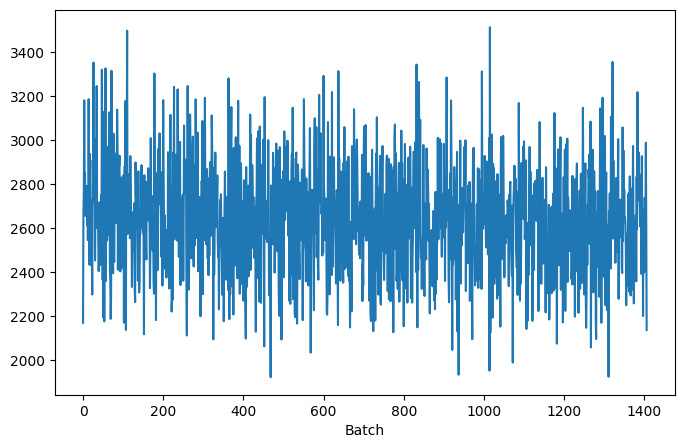

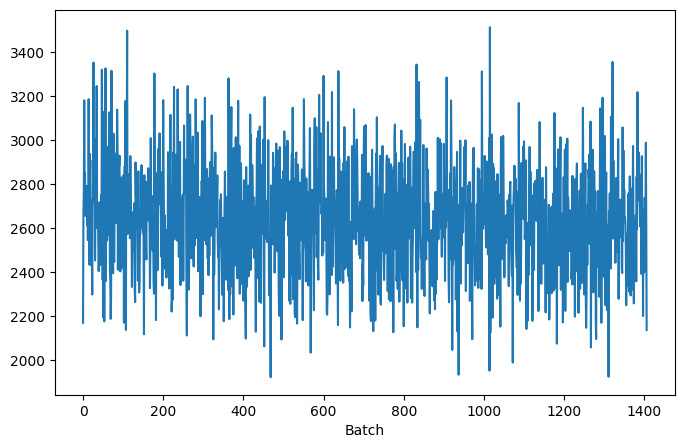

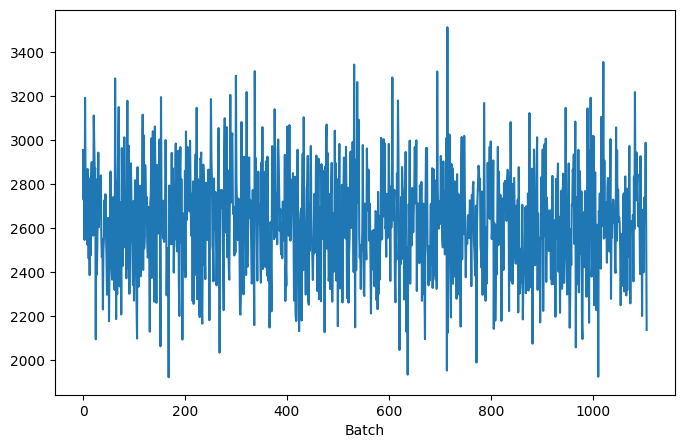

In [33]:
PLOTUPDATES = True
updateRate = 1
n_epochs = 3

opt = torch.optim.Adam(model.parameters(), lr=1e-4) 

loss_fn = nn.MSELoss(reduction='sum')
losses = []

if PLOTUPDATES:
    fig, ax = plt.subplots(figsize=(8, 5))

for epoch in range(n_epochs):
    opt.zero_grad()
    for batch, labels in tqdm(trainDataloader):

        timesteps = torch.randint(0, scheduler.TrainSteps - 1, (batch.shape[0],), device='cpu').long()

        noisyImg, noiseMask = scheduler.addNoise(batch, timesteps)

        pred = model(noisyImg.to(device), timesteps.to(device), labels.to(device))
        pred = F.sigmoid(pred) # Do i round the values?

        loss = loss_fn(pred, noiseMask.to(device)) 

        # Backprop and update the params:
        opt.zero_grad()
        loss.backward()
        opt.step()
        losses.append(loss.item())

    if PLOTUPDATES:
        if epoch % updateRate == 0:
            clear_output(wait=True)  
            ax.clear()
            plt.plot(losses)
            plt.xlabel('Batch')
            display(fig)
            
fig, ax = plt.subplots(figsize=(8, 5))
plt.plot(losses[300:])
plt.xlabel('Batch')
plt.show()

100%|██████████| 100/100 [00:01<00:00, 98.94it/s]


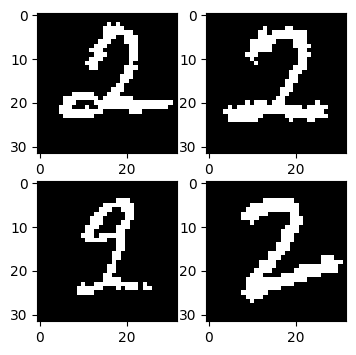

In [46]:
#Inference # I think the issue is that is is trying to remove all the noise in a single step

x = torch.randint(0, 2, (4, 1, 32, 32), device=device).float()
labels = torch.tensor([2, 2, 2, 2], device=device)
inferenceSteps = torch.linspace(scheduler.TrainSteps-1, 1, 100, device=device)

for t in tqdm(inferenceSteps):
    t = t.long()
    with torch.no_grad():
        pred = torch.sigmoid(model(x, t, labels)).round()
    x = scheduler.denoise(x, pred, t)

# argmax_images = torch.argmax(x, dim=1, keepdim=True)
# Show the results
fig, axs = plt.subplots(2, 2, figsize=(4, 4))
axs[0, 0].imshow(x[0,0].cpu(), cmap='gray')
axs[0, 1].imshow(x[1,0].cpu(), cmap='gray')
axs[1, 0].imshow(x[2,0].cpu(), cmap='gray')
axs[1, 1].imshow(x[3,0].cpu(), cmap='gray')


plt.show()

100%|██████████| 100/100 [00:07<00:00, 13.93it/s]


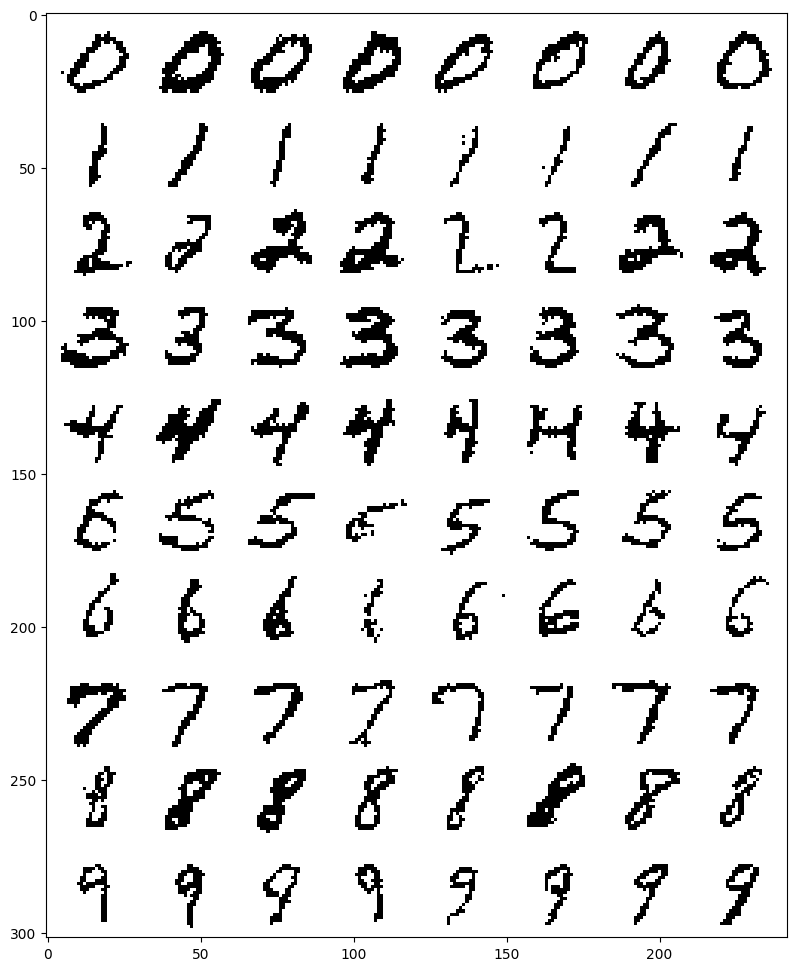

In [59]:
# Inference

model.eval()

x = torch.randint(0, 2, (80, 1, 28, 28), device=device).float()
y = torch.tensor([[i]*8 for i in range(10)]).flatten().to(device)
y_uncond = torch.zeros_like(y) # unconditional samples

guidance_scale = 7.5

inferenceSteps = torch.linspace(scheduler.TrainSteps-1, 1, scheduler.TrainSteps, device=device)  

# Sampling loop
for t in tqdm(inferenceSteps):
    t = t.long()
    # Get model pred
    with torch.no_grad():
        # Get unconditioned and conditioned predictions
        residual_uncond = model(x, t, y_uncond)  # Without conditioning
        residual_cond = model(x, t, y)           # With conditioning
        
        # Apply CFG: interpolate between uncond & cond
        residual = residual_uncond + guidance_scale * (residual_cond - residual_uncond)

    # Update sample with step
    x = scheduler.denoise(
        x, 
        torch.sigmoid(residual_cond).round(), 
        t)

# Show the results
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
ax.imshow(torchvision.utils.make_grid(x.detach().cpu().clip(-1, 1), nrow=8)[0], cmap='Greys')